In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import copy


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root='/content/drive/MyDrive/skin_cancer_dataset/ISBI2017_dataset/train', transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Split training data among clients
num_clients = 3
client_datasets = torch.utils.data.random_split(train_dataset, [len(train_dataset)//num_clients]*num_clients)
client_loaders = [DataLoader(ds, batch_size=32, shuffle=True) for ds in client_datasets]


In [13]:
def get_vgg16_model(num_classes=2):
    model = models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model


In [14]:
def local_train_fedprox(model, global_weights, train_loader, optimizer, criterion, mu=0.01, device='cpu', epochs=1):
    model.train()
    model.to(device)

    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # FedProx proximal term
            proximal_term = 0.0
            for w, w_t in zip(model.parameters(), global_weights):
                proximal_term += ((w - w_t.to(device)) ** 2).sum()
            loss += (mu / 2) * proximal_term

            loss.backward()
            optimizer.step()

    return model.state_dict()


In [15]:
def fedavg(local_weights):
    avg_weights = copy.deepcopy(local_weights[0])
    for key in avg_weights.keys():
        for i in range(1, len(local_weights)):
            avg_weights[key] += local_weights[i][key]
        avg_weights[key] = torch.div(avg_weights[key], len(local_weights))
    return avg_weights


In [16]:
def evaluate_metrics(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return {
        'Accuracy': accuracy_score(all_labels, all_preds) * 100,
        'Precision': precision_score(all_labels, all_preds, zero_division=0) * 100,
        'Recall': recall_score(all_labels, all_preds, zero_division=0) * 100,
        'F1-Score': f1_score(all_labels, all_preds, zero_division=0) * 100,
        'AUC': roc_auc_score(all_labels, all_probs) * 100
    }


In [17]:
from torch.utils.data import DataLoader, random_split, Subset

# Assume 'train_dataset' is already defined (e.g., from random_split or a subset of ISIC2016)
num_clients = 3
client_data_size = len(train_dataset) // num_clients

# Split the training data into equal parts for each client
client_datasets = [Subset(train_dataset, list(range(i * client_data_size, (i + 1) * client_data_size)))
                   for i in range(num_clients)]

# Create data loaders for each client
client_loaders = [DataLoader(client_datasets[i], batch_size=32, shuffle=True) for i in range(num_clients)]


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model = get_vgg16_model().to(device)
global_weights = copy.deepcopy(global_model.state_dict())

rounds = 10
mu = 0.01
criterion = nn.CrossEntropyLoss()

for round in range(rounds):
    print(f"\n--- Round {round+1} ---")
    local_weights = []

    for i, client_loader in enumerate(client_loaders):
        local_model = get_vgg16_model().to(device)
        local_model.load_state_dict(global_weights)

        optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.9)

        local_w = local_train_fedprox(
            model=local_model,
            global_weights=list(global_model.parameters()),
            train_loader=client_loader,
            optimizer=optimizer,
            criterion=criterion,
            mu=mu,
            device=device
        )

        local_weights.append(local_w)

    # FedAvg aggregation
    avg_weights = fedavg(local_weights)
    global_model.load_state_dict(avg_weights)
    global_weights = copy.deepcopy(global_model.state_dict())

    # Evaluation
    metrics = evaluate_metrics(global_model, test_loader, device=device)
    print(f"Accuracy: {metrics['Accuracy']:.2f}%, "
          f"Precision: {metrics['Precision']:.2f}%, Recall: {metrics['Recall']:.2f}%, "
          f"F1: {metrics['F1-Score']:.2f}%, AUC: {metrics['AUC']:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Round 1 ---
Accuracy: 86.39%, Precision: 60.38%, Recall: 53.33%, F1: 56.64%, AUC: 90.67%

--- Round 2 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 87.22%, Precision: 73.33%, Recall: 36.67%, F1: 48.89%, AUC: 94.04%

--- Round 3 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 89.17%, Precision: 74.42%, Recall: 53.33%, F1: 62.14%, AUC: 95.29%

--- Round 4 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 89.44%, Precision: 80.56%, Recall: 48.33%, F1: 60.42%, AUC: 96.05%

--- Round 5 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 91.67%, Precision: 80.00%, Recall: 66.67%, F1: 72.73%, AUC: 96.58%

--- Round 6 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 91.94%, Precision: 78.18%, Recall: 71.67%, F1: 74.78%, AUC: 97.05%

--- Round 7 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 93.06%, Precision: 78.69%, Recall: 80.00%, F1: 79.34%, AUC: 97.34%

--- Round 8 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 93.33%, Precision: 83.33%, Recall: 75.00%, F1: 78.95%, AUC: 97.71%

--- Round 9 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 93.61%, Precision: 83.64%, Recall: 76.67%, F1: 80.00%, AUC: 97.97%

--- Round 10 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 93.89%, Precision: 85.19%, Recall: 76.67%, F1: 80.70%, AUC: 98.19%


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Melanoma"], yticklabels=["Benign", "Melanoma"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


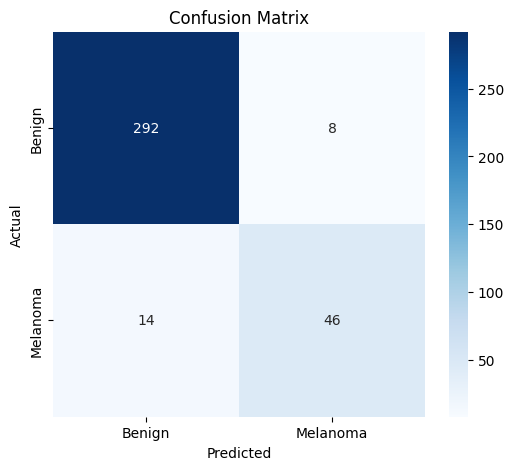

In [20]:
plot_confusion_matrix(global_model, test_loader, device=device)


In [23]:
TP=46
TN=292
FP=8
FN=14
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 46.000000 TN: 292.000000 FP: 8.000000 FN: 14.000000


In [24]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


acc: 0.93889
Specificity: 0.97333
 Recall: 0.76667
 Precision: 0.85185
F1 Score: 0.80702


In [25]:
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)

# Compute MCC
mcc_score = matthews_corrcoef(y_true, y_pred)

# Compute Cohen’s Kappa
kappa_score = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"AUC: {auc_score:.5f}")
print(f"MCC: {mcc_score:.5f}")
print(f"Cohen's Kappa: {kappa_score:.5f}")


AUC: 0.87000
MCC: 0.77234
Cohen's Kappa: 0.77083


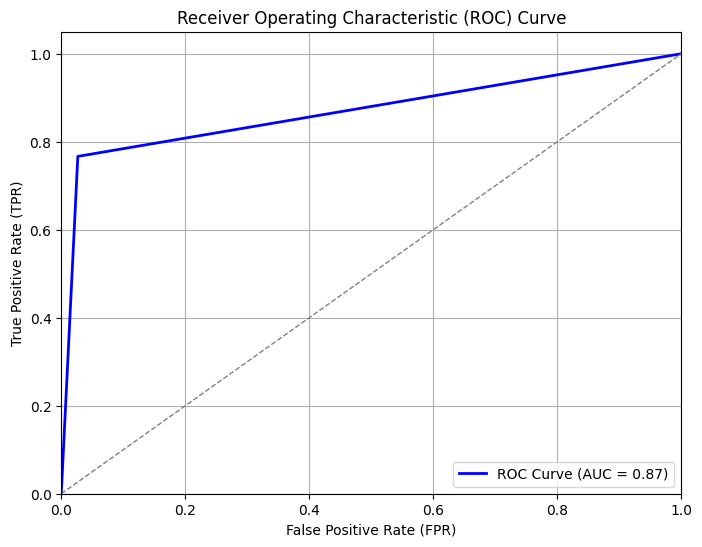

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

In [22]:
# Average loss over all clients (optional addition to local_train_fedprox to return avg loss)
total_loss = 0
total_batches = 0
for i, client_loader in enumerate(client_loaders):
    ...
    # Track loss (optional: modify local_train_fedprox to return loss)
    for images, labels in client_loader:
        ...
        total_loss += loss.item()
        total_batches += 1

train_loss_per_round.append(total_loss / total_batches)


NameError: name 'loss' is not defined

In [ ]:
plt.plot(range(1, len(train_loss_per_round)+1), train_loss_per_round, marker='o')
plt.xlabel('Federated Round')
plt.ylabel('Average Training Loss')
plt.title('Training Loss per Round')
plt.grid(True)
plt.show()
